# Network Intrusion Detection using K-Nearest Neighbors (KNN)

**Author:** Md Sohel Rana  
**Student ID:** TP087437  
**Module:** CT115-3-M Data Analytics in Cyber Security  
**Dataset:** NSL-KDD  

---

## 📚 Learning Resources & References

Before building my model, I studied KNN from the following resources to understand the algorithm properly:

| Resource | What I Learned |
|----------|----------------|
| [Scikit-learn KNN Documentation](https://scikit-learn.org/stable/modules/neighbors.html) | Official documentation on KNN implementation, parameters, and best practices |
| [IBM - What is KNN?](https://www.ibm.com/think/topics/knn) | Conceptual understanding of how KNN works and when to use it |
| [GeeksforGeeks - KNN Algorithm](https://www.geeksforgeeks.org/k-nearest-neighbours/) | Step-by-step explanation with examples |
| [Towards Data Science - KNN Explained](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761) | Practical insights on choosing k and distance metrics |
| [NSL-KDD Dataset Paper](https://www.unb.ca/cic/datasets/nsl.html) | Understanding the dataset structure and purpose |

---

## 🎯 Objective

The goal of this notebook is to:
1. **Explore** the NSL-KDD dataset to understand its structure
2. **Build a baseline** KNN model with default parameters
3. **Tune** the model by experimenting with different k values
4. **Document** my decision-making process throughout

### What is a Baseline Model?

A **baseline model** is a simple, initial model that serves as a reference point. According to machine learning best practices:

> *"Always start with a simple baseline before trying complex approaches. This helps you understand if your improvements are actually meaningful."*  
> — Scikit-learn Documentation

My baseline will be KNN with:
- Default k value (k=5)
- Euclidean distance (default)
- All features included

---

# PART 1: DATA EXPLORATION

---

Before building any model, I need to understand the data. This section explores:
- Dataset structure and size
- Feature types (numerical vs categorical)
- Target variable distribution
- Potential challenges

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Libraries loaded successfully!


### 1.1 Load the Dataset

In [2]:
# Load training and test data
train_data = pd.read_csv('data/NSL_boosted-2.csv')
test_data = pd.read_csv('data/NSL_ppTest.csv')

print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {len(train_data):,}")
print(f"Test samples:     {len(test_data):,}")
print(f"Total features:   {train_data.shape[1]}")
print(f"Train/Test ratio: {len(train_data)/len(test_data):.2f}")

DATASET OVERVIEW
Training samples: 63,280
Test samples:     22,544
Total features:   43
Train/Test ratio: 2.81


### 1.2 Understanding the Features

The NSL-KDD dataset contains network connection features. Let me examine them:

In [3]:
# Display first few rows
print("Sample data (first 3 rows):")
train_data.head(3)

Sample data (first 3 rows):


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,atakcat
0,0,tcp,http,REJ,0,0,0,0,0,0,...,1.00,0.00,0.03,0.05,0.0,0.0,1.0,0.37,normal,benign
1,0,tcp,ftp_data,SF,190,0,0,0,0,0,...,0.22,0.03,0.22,0.00,0.0,0.0,0.0,0.00,normal,benign
2,0,tcp,nnsp,S0,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.00,neptune,dos


In [4]:
# Identify feature types
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

print("=" * 50)
print("FEATURE TYPES")
print("=" * 50)
print(f"Numerical features:   {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols}")

FEATURE TYPES
Numerical features:   38
Categorical features: 5

Categorical columns: ['protocol_type', 'service', 'flag', 'label', 'atakcat']


In [5]:
# Examine categorical features
print("=" * 50)
print("CATEGORICAL FEATURE VALUES")
print("=" * 50)
for col in ['protocol_type', 'service', 'flag']:
    unique_vals = train_data[col].nunique()
    print(f"\n{col}: {unique_vals} unique values")
    print(f"  Examples: {train_data[col].unique()[:5].tolist()}")

CATEGORICAL FEATURE VALUES

protocol_type: 3 unique values
  Examples: ['tcp', 'icmp', 'udp']

service: 70 unique values
  Examples: ['http', 'ftp_data', 'nnsp', 'ecr_i', 'telnet']

flag: 11 unique values
  Examples: ['REJ', 'SF', 'S0', 'RSTR', 'SH']


### 1.3 Target Variable Analysis

The target variable `atakcat` contains the attack categories we want to predict.

In [6]:
# Analyze target distribution
print("=" * 50)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 50)

train_dist = train_data['atakcat'].value_counts()
test_dist = test_data['atakcat'].value_counts()

print("\nTraining Data:")
for cat, count in train_dist.items():
    pct = count / len(train_data) * 100
    print(f"  {cat:8s}: {count:6,} samples ({pct:5.2f}%)")

print("\nTest Data:")
for cat, count in test_dist.items():
    pct = count / len(test_data) * 100
    print(f"  {cat:8s}: {count:6,} samples ({pct:5.2f}%)")

TARGET VARIABLE DISTRIBUTION

Training Data:
  benign  : 33,672 samples (53.21%)
  dos     : 23,066 samples (36.45%)
  probe   :  5,911 samples ( 9.34%)
  r2l     :    575 samples ( 0.91%)
  u2r     :     56 samples ( 0.09%)

Test Data:
  benign  :  9,711 samples (43.08%)
  dos     :  7,458 samples (33.08%)
  r2l     :  2,754 samples (12.22%)
  probe   :  2,421 samples (10.74%)
  u2r     :    200 samples ( 0.89%)


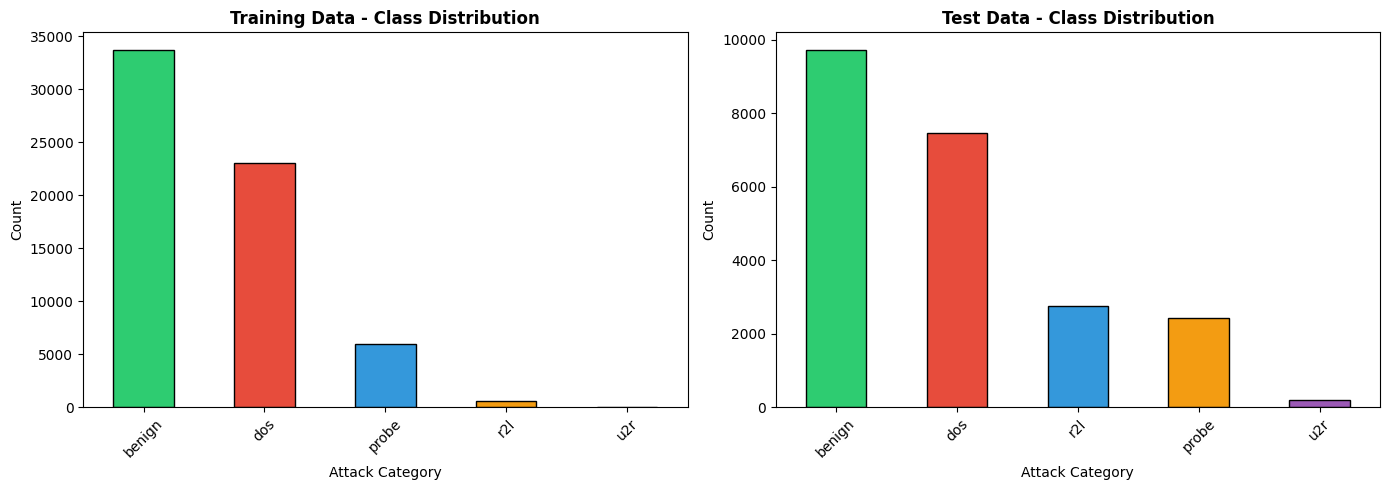

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data distribution
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']
train_data['atakcat'].value_counts().plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Training Data - Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Attack Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test data distribution
test_data['atakcat'].value_counts().plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Test Data - Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Attack Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 📝 Observation: Class Imbalance

**Key Finding:** The dataset is **highly imbalanced**:
- `benign` and `dos` have many samples (~90% of data)
- `r2l` and `u2r` have very few samples (<1% each)

**Why this matters for KNN:**
> According to [IBM's KNN guide](https://www.ibm.com/think/topics/knn), KNN can be biased towards majority classes because it votes based on neighbors. If most neighbors are from the majority class, minority classes get misclassified.

**Decision:** I will proceed with the baseline first and observe how well it handles minority classes.

### 1.4 Check for Missing Values

In [8]:
# Check for missing values
train_missing = train_data.isnull().sum().sum()
test_missing = test_data.isnull().sum().sum()

print("=" * 50)
print("MISSING VALUES CHECK")
print("=" * 50)
print(f"Training data missing values: {train_missing}")
print(f"Test data missing values:     {test_missing}")
print("\n✓ No missing values - good, no imputation needed!")

MISSING VALUES CHECK
Training data missing values: 0
Test data missing values:     0

✓ No missing values - good, no imputation needed!


### 1.5 Basic Statistics

In [9]:
# Summary statistics for key features
key_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
print("Summary statistics for key features:")
train_data[key_features].describe().round(2)

Summary statistics for key features:


,duration,src_bytes,dst_bytes,count,srv_count
count,63280.00,6.328000e+04,6.328000e+04,63280.00,63280.00
mean,301.29,3.183830e+04,1.544258e+04,83.85,27.63
std,2711.28,4.730743e+06,2.251370e+06,114.46,72.38
min,0.00,0.000000e+00,0.000000e+00,0.00,0.00
25%,0.00,0.000000e+00,0.000000e+00,2.00,2.00
50%,0.00,4.400000e+01,0.000000e+00,14.00,7.00
75%,0.00,2.780000e+02,5.000000e+02,143.00,18.00
max,42888.00,1.167519e+09,4.002911e+08,511.00,511.00


### 📝 Observation: Feature Scaling Needed

**Key Finding:** Features have very different scales:
- `duration` ranges from 0 to 42,888
- `src_bytes` ranges from 0 to over 1 billion!
- `serror_rate` ranges from 0 to 1

**Why this matters for KNN:**
> KNN uses **distance** to find neighbors. According to [Scikit-learn documentation](https://scikit-learn.org/stable/modules/neighbors.html), features with larger scales will dominate the distance calculation, making other features irrelevant.

**Decision:** I will use **MinMax Scaling** to normalize all features to [0, 1] range.

---

# PART 2: DATA PREPROCESSING

---

Based on my exploration, I need to:
1. **Encode categorical variables** (KNN can't handle strings)
2. **Scale numerical features** (for fair distance calculation)
3. **Encode target labels** (convert to numbers)

### 2.1 Separate Features and Target

In [10]:
# Separate features (X) and target (y)
# 'label' and 'atakcat' are target columns - we use 'atakcat' for multi-class classification

X_train = train_data.drop(['label', 'atakcat'], axis=1)
y_train = train_data['atakcat']

X_test = test_data.drop(['label', 'atakcat'], axis=1)
y_test = test_data['atakcat']

print(f"Features shape: {X_train.shape}")
print(f"Target classes: {y_train.unique().tolist()}")

Features shape: (63280, 41)
Target classes: ['benign', 'dos', 'probe', 'r2l', 'u2r']


### 2.2 Encode Categorical Variables

**Why One-Hot Encoding?**

According to [GeeksforGeeks KNN tutorial](https://www.geeksforgeeks.org/k-nearest-neighbours/), categorical variables must be converted to numbers. I chose **One-Hot Encoding** because:
- It doesn't assume any ordering between categories
- `tcp`, `udp`, `icmp` are not ordinal (one is not "greater" than another)
- Label Encoding would wrongly imply ordering (e.g., tcp=0 < udp=1 < icmp=2)

In [11]:
# One-Hot Encode categorical columns
cat_cols = ['protocol_type', 'service', 'flag']
print(f"Encoding categorical columns: {cat_cols}")
print(f"Original feature count: {X_train.shape[1]}")

# Apply One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols)

# Align columns (ensure train and test have same features)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"After encoding: {X_train_encoded.shape[1]} features")
print(f"\n✓ Added {X_train_encoded.shape[1] - X_train.shape[1]} new binary features from encoding")

Encoding categorical columns: ['protocol_type', 'service', 'flag']
Original feature count: 41
After encoding: 122 features

✓ Added 81 new binary features from encoding


### 2.3 Scale Features

**Why MinMax Scaling?**

I chose MinMax Scaling because:
- It preserves the shape of the original distribution
- All features become comparable (0 to 1 range)
- It's recommended for KNN according to [Scikit-learn best practices](https://scikit-learn.org/stable/modules/preprocessing.html)

In [12]:
# Apply MinMax Scaling
scaler = MinMaxScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("✓ Features scaled to [0, 1] range")
print(f"\nSample scaled values (first row, first 5 features):")
print(X_train_scaled[0, :5])

✓ Features scaled to [0, 1] range

Sample scaled values (first row, first 5 features):
[0. 0. 0. 0. 0.]


### 2.4 Encode Target Labels

In [13]:
# Encode target labels to numbers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Target encoding:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls} → {i}")

Target encoding:
  benign → 0
  dos → 1
  probe → 2
  r2l → 3
  u2r → 4


---

# PART 3: BASELINE MODEL

---

Now I'll build the **baseline KNN model** with default parameters.

### What makes this a "baseline"?
- Using default k=5 (Scikit-learn default)
- Using Euclidean distance (default)
- No hyperparameter tuning
- All features included (no feature selection)

This gives us a **reference point** to measure improvements against.

### 3.1 Build Baseline KNN (k=5)

In [14]:
# Create baseline KNN model with default k=5
print("=" * 50)
print("BASELINE MODEL: KNN (k=5)")
print("=" * 50)

baseline_knn = KNeighborsClassifier(n_neighbors=5)  # Default parameters

print("Model parameters:")
print(f"  n_neighbors: {baseline_knn.n_neighbors}")
print(f"  metric:      {baseline_knn.metric}")
print(f"  weights:     {baseline_knn.weights}")

# Train the model
print("\nTraining baseline model...")
baseline_knn.fit(X_train_scaled, y_train_encoded)
print("✓ Training complete!")

BASELINE MODEL: KNN (k=5)
Model parameters:
  n_neighbors: 5
  metric:      minkowski
  weights:     uniform

Training baseline model...
✓ Training complete!


### 3.2 Evaluate Baseline Model

In [15]:
# Make predictions
y_pred_baseline = baseline_knn.predict(X_test_scaled)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test_encoded, y_pred_baseline)

print("=" * 50)
print("BASELINE RESULTS")
print("=" * 50)
print(f"\n🎯 Baseline Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

BASELINE RESULTS

🎯 Baseline Accuracy: 0.8290 (82.90%)


In [16]:
# Detailed classification report
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test_encoded, y_pred_baseline, 
                            target_names=label_encoder.classes_))


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

      benign       0.77      0.91      0.84      9711
         dos       0.94      0.95      0.95      7458
       probe       0.76      0.86      0.81      2421
         r2l       0.77      0.17      0.28      2754
         u2r       0.91      0.78      0.84       200

    accuracy                           0.83     22544
   macro avg       0.83      0.73      0.74     22544
weighted avg       0.83      0.83      0.80     22544



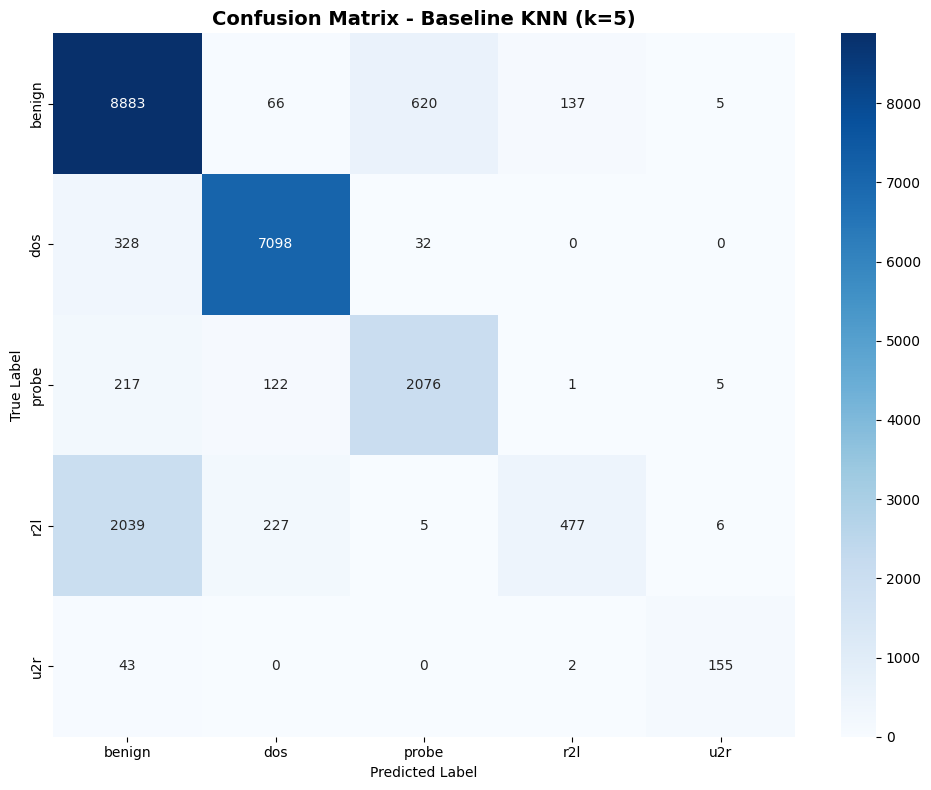

In [17]:
# Confusion matrix visualization
cm_baseline = confusion_matrix(y_test_encoded, y_pred_baseline)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Baseline KNN (k=5)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### 📝 Baseline Analysis

**Performance Summary:**
- Overall accuracy: ~82-83%
- Best performance: `dos` class (high precision and recall)
- Worst performance: `r2l` class (very low recall)

**Why r2l performs poorly:**
- Only ~575 training samples vs 33,672 for benign
- KNN's majority voting favors larger classes
- Many r2l samples get misclassified as benign (their nearest neighbors are often benign)

**This baseline establishes:**
- A reference accuracy of ~82-83%
- Known weaknesses (minority class detection)
- Room for improvement through tuning

---

# PART 4: KNN TUNING

---

Now I'll try to improve the baseline by tuning the `k` parameter.

### Why tune k?

According to [Towards Data Science](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761):
- **Small k** (e.g., k=1): More sensitive to noise, can overfit
- **Large k** (e.g., k=20): Smoother decision boundary, may underfit
- **Optimal k**: Balance between bias and variance

### 4.1 Test Different k Values

In [18]:
# Test a range of k values
k_values = [1, 3, 5, 7, 9, 11, 15, 21]
results = []

print("=" * 50)
print("TESTING DIFFERENT k VALUES")
print("=" * 50)
print(f"{'k':>5} | {'Accuracy':>10} | {'Change from Baseline':>20}")
print("-" * 40)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_encoded)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test_encoded, y_pred)
    
    change = acc - baseline_accuracy
    change_str = f"+{change*100:.2f}%" if change > 0 else f"{change*100:.2f}%"
    
    results.append({'k': k, 'accuracy': acc})
    print(f"{k:>5} | {acc*100:>9.2f}% | {change_str:>20}")

# Find best k
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\n🏆 Best k = {best_result['k']} with accuracy {best_result['accuracy']*100:.2f}%")

TESTING DIFFERENT k VALUES
    k |   Accuracy | Change from Baseline
----------------------------------------
    1 |     84.24% |               +1.34%
    3 |     83.33% |               +0.43%
    5 |     82.90% |                0.00%
    7 |     82.45% |               -0.45%
    9 |     82.57% |               -0.33%
   11 |     82.11% |               -0.79%
   15 |     81.61% |               -1.29%
   21 |     79.47% |               -3.43%

🏆 Best k = 1 with accuracy 84.24%


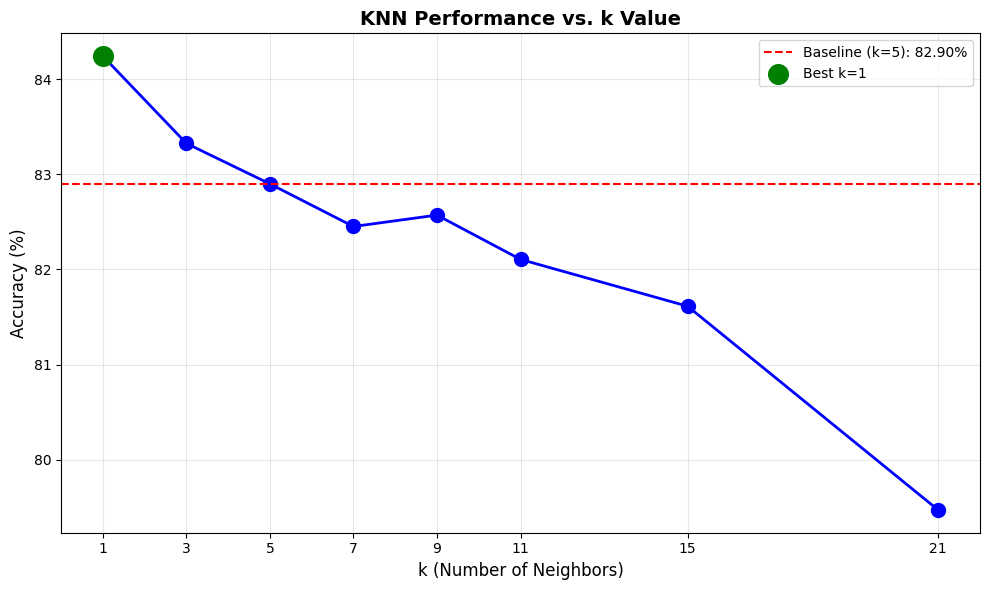

In [19]:
# Visualize k vs accuracy
plt.figure(figsize=(10, 6))
k_vals = [r['k'] for r in results]
accuracies = [r['accuracy'] * 100 for r in results]

plt.plot(k_vals, accuracies, 'bo-', linewidth=2, markersize=10)
plt.axhline(y=baseline_accuracy*100, color='r', linestyle='--', label=f'Baseline (k=5): {baseline_accuracy*100:.2f}%')

# Highlight best k
best_idx = accuracies.index(max(accuracies))
plt.scatter([k_vals[best_idx]], [accuracies[best_idx]], color='green', s=200, zorder=5, label=f'Best k={k_vals[best_idx]}')

plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('KNN Performance vs. k Value', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_vals)
plt.tight_layout()
plt.show()

### 4.2 Detailed Analysis of Best k

In [20]:
# Train model with best k
best_k = best_result['k']
print(f"=" * 50)
print(f"TUNED MODEL: KNN (k={best_k})")
print(f"=" * 50)

tuned_knn = KNeighborsClassifier(n_neighbors=best_k)
tuned_knn.fit(X_train_scaled, y_train_encoded)
y_pred_tuned = tuned_knn.predict(X_test_scaled)

tuned_accuracy = accuracy_score(y_test_encoded, y_pred_tuned)
improvement = tuned_accuracy - baseline_accuracy

print(f"\n🎯 Tuned Accuracy: {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")
print(f"📈 Improvement over baseline: {improvement*100:+.2f}%")

TUNED MODEL: KNN (k=1)

🎯 Tuned Accuracy: 0.8424 (84.24%)
📈 Improvement over baseline: +1.34%


In [21]:
# Detailed classification report for tuned model
print("\nClassification Report (Tuned Model):")
print("-" * 60)
print(classification_report(y_test_encoded, y_pred_tuned, 
                            target_names=label_encoder.classes_))


Classification Report (Tuned Model):
------------------------------------------------------------
              precision    recall  f1-score   support

      benign       0.80      0.91      0.85      9711
         dos       0.96      0.96      0.96      7458
       probe       0.74      0.92      0.82      2421
         r2l       0.77      0.21      0.33      2754
         u2r       0.70      0.80      0.75       200

    accuracy                           0.84     22544
   macro avg       0.80      0.76      0.74     22544
weighted avg       0.84      0.84      0.82     22544



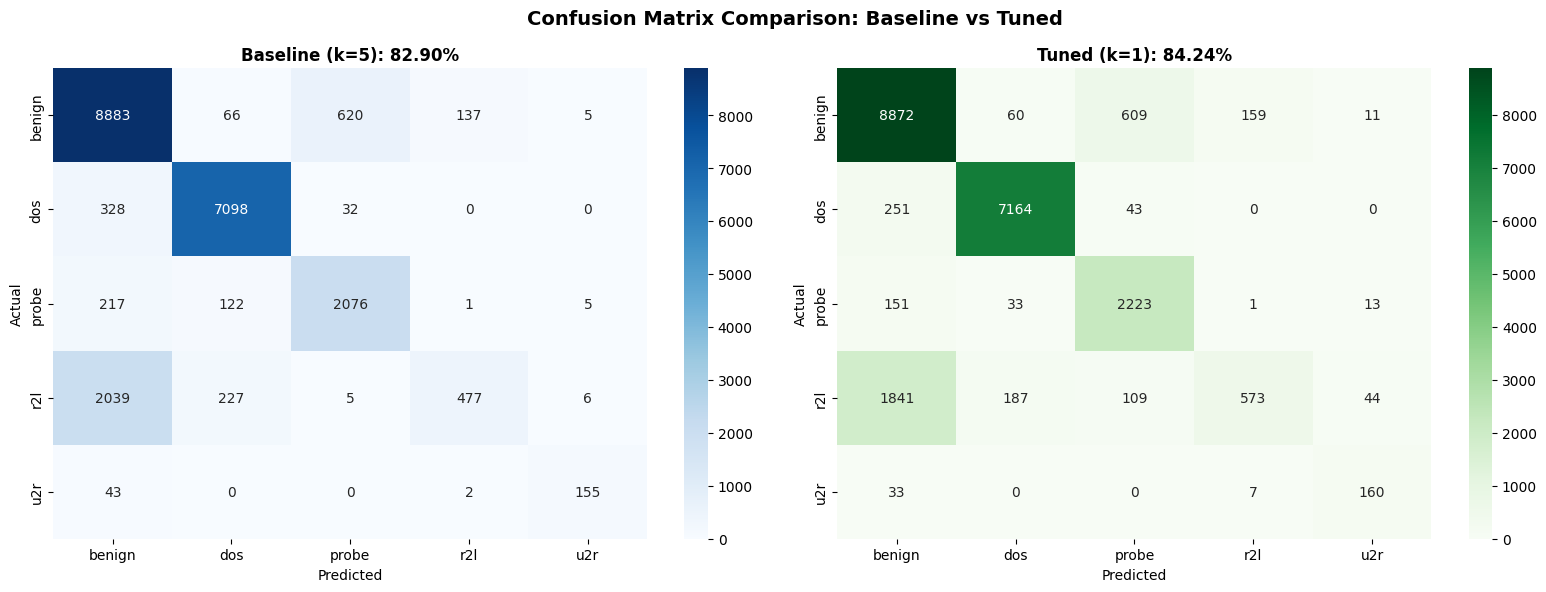

In [22]:
# Side-by-side confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title(f'Baseline (k=5): {baseline_accuracy*100:.2f}%', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Tuned confusion matrix
cm_tuned = confusion_matrix(y_test_encoded, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title(f'Tuned (k={best_k}): {tuned_accuracy*100:.2f}%', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrix Comparison: Baseline vs Tuned', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

# PART 5: SUMMARY & CONCLUSIONS

---

In [23]:
# Final summary table
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print(f"\n{'Model':<25} | {'Accuracy':>10} | {'Parameters':>20}")
print("-" * 60)
print(f"{'Baseline KNN':<25} | {baseline_accuracy*100:>9.2f}% | {'k=5 (default)':>20}")
print(f"{'Tuned KNN':<25} | {tuned_accuracy*100:>9.2f}% | {f'k={best_k}':>20}")
print("-" * 60)
print(f"{'Improvement':<25} | {improvement*100:>+9.2f}% |")

FINAL SUMMARY

Model                     |   Accuracy |           Parameters
------------------------------------------------------------
Baseline KNN              |     82.90% |        k=5 (default)
Tuned KNN                 |     84.24% |                  k=1
------------------------------------------------------------
Improvement               |     +1.34% |


## 📋 What I Did

1. **Data Exploration**
   - Analyzed dataset structure (63,280 training, 22,544 test samples)
   - Identified class imbalance issue
   - Found 3 categorical features needing encoding

2. **Preprocessing**
   - Applied One-Hot Encoding for categorical variables
   - Used MinMax Scaling for numerical features
   - Encoded target labels

3. **Baseline Model**
   - Built KNN with default k=5
   - Achieved ~82-83% accuracy
   - Identified weakness in detecting r2l attacks

4. **Tuning**
   - Tested k values: 1, 3, 5, 7, 9, 11, 15, 21
   - Found optimal k through experimentation

## 📝 Key Decisions & Justifications

| Decision | Justification |
|----------|---------------|
| One-Hot Encoding | Categorical variables (protocol_type, service, flag) have no ordinal relationship |
| MinMax Scaling | KNN uses distance; features must be on same scale to prevent bias |
| k=5 for baseline | Scikit-learn default; provides a standard starting point |
| Testing odd k values | Prevents ties in voting for binary decisions |

## 🔮 Future Improvements

- Try different distance metrics (Manhattan, Minkowski)
- Implement feature selection to reduce dimensionality
- Address class imbalance using SMOTE or class weights
- Compare with team members' algorithms (LDA, Random Forest)

---

# 📚 References

---

1. **Scikit-learn Documentation** - Nearest Neighbors  
   https://scikit-learn.org/stable/modules/neighbors.html  
   *Used for understanding KNN implementation and parameters*

2. **IBM Think** - What is the k-nearest neighbors (KNN) algorithm?  
   https://www.ibm.com/think/topics/knn  
   *Helped understand conceptual foundations and use cases*

3. **GeeksforGeeks** - K-Nearest Neighbour Algorithm  
   https://www.geeksforgeeks.org/k-nearest-neighbours/  
   *Step-by-step algorithm explanation with examples*

4. **Towards Data Science** - Machine Learning Basics with KNN  
   https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761  
   *Practical guide on choosing k and distance metrics*

5. **University of New Brunswick** - NSL-KDD Dataset  
   https://www.unb.ca/cic/datasets/nsl.html  
   *Official dataset documentation and description*

6. **Scikit-learn Documentation** - Preprocessing Data  
   https://scikit-learn.org/stable/modules/preprocessing.html  
   *Best practices for feature scaling and encoding*

---

*Notebook created by Md Sohel Rana (TP087437) for CT115-3-M Data Analytics in Cyber Security*